# Definindo sistema


In [1]:
import numpy as np
import torch
from scipy.integrate import solve_ivp

from plots import plot_tanks

np.random.seed(42)

# Constantes
a1 = 50  # cm^2
a2 = 50  # cm^2
cv1 = 1
cv2 = 1


def F(t, op=np):
    f = 5 - (t**2) / 3000
    return op.where(f < 0.0, 0.0, f)


def edo_np(t, Y):
    h1, h2 = Y[0], Y[1]

    # Tanks limits
    h1 = np.where(h1 < 0.0, 0.0, h1)
    h2 = np.where(h2 < 0.0, 0.0, h2)

    # Equations
    dh1dt = (F(t) - cv1 * np.sqrt(h1)) / a1
    dh2dt = (cv1 * np.sqrt(h1) - cv2 * np.sqrt(h2)) / a2
    return np.array([dh1dt, dh2dt])


t = np.linspace(0, 300, 300)
t_tensor = torch.tensor(t, dtype=torch.float32, requires_grad=True).unsqueeze(1)
y0 = np.array([0, 0])

sol = solve_ivp(edo_np, [t[0], t[-1]], y0, t_eval=t)
h1_exp = sol.y[0] + np.random.normal(0, 1, len(t)) * 0.1
h2_exp = sol.y[1] + np.random.normal(0, 1, len(t)) * 0.1

plot_tanks(
    t, [h1_exp, h2_exp], ["h1 (exp)", "h2 (exp)"], scatter=2, filename="exp_tanks"
)

# plt.figure(figsize=(10, 4), layout="constrained")
# plt.plot(t, F(t), label="F")
# plt.show()


# Definindo rede neural


In [2]:
from torch import nn


class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 1  # t
        hidden_size = 8
        output_size = 2  # h1, h2

        self.hidden_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        output = self.hidden_layer((x * 2 / torch.max(t_tensor)) - 1)
        return torch.abs((output + 1) * (torch.max(h1_exp) / 2))


## Definindo função Loss


In [3]:
from utils import dydx, mean_square

h1_exp = torch.tensor(h1_exp, dtype=torch.float32)
h2_exp = torch.tensor(h2_exp, dtype=torch.float32)


def edo_torch(t, Y):
    h1, h2 = Y

    # Equations
    dh1dt = (F(t, torch) - cv1 * torch.sqrt(h1)) / a1
    dh2dt = (cv1 * torch.sqrt(h1) - cv2 * torch.sqrt(h2)) / a2
    return [dh1dt, dh2dt]


def loss_fn(model, t):
    # Loss das EDOs
    Y_pred = model(t)
    h1_pred, h2_pred = Y_pred[:, 0], Y_pred[:, 1]

    dh1dt_pinn, dh2dt_pinn = dydx(t, h1_pred), dydx(t, h2_pred)
    dh1dt_edo, dh2dt_edo = edo_torch(t, [h1_pred, h2_pred])

    loss_EDO1 = mean_square(dh1dt_pinn - dh1dt_edo)
    loss_EDO2 = mean_square(dh2dt_pinn - dh2dt_edo)

    # Loss das condições iniciais
    t0 = torch.tensor([[0.0]], requires_grad=True)
    Y0 = model(t0)
    h1_0, h2_0 = Y0[:, 0], Y0[:, 1]

    loss_ic1 = mean_square(h1_0 - y0[0])
    loss_ic2 = mean_square(h2_0 - y0[1])

    # Loss dos dados
    loss_data_h1 = mean_square(h1_pred - h1_exp)
    loss_data_h2 = mean_square(h2_pred - h2_exp)

    # Loss total
    loss_total = (
        loss_EDO1 + loss_EDO2 + loss_data_h1 + loss_data_h2 + loss_ic1 + loss_ic2
    )

    return loss_total


# Testando métodos


In [4]:
n_execuções = 2
target_loss = 0.1

Adam_study_path = "../results/Adam-studies.hkl"
Adam_results_path = "../results/Adam-speeds.hkl"
Adam_model_path = "../results/Adam-model.pt"


## Adam


### Otimizando hiperparametros


In [5]:
import os

import hickle as hkl
import optuna


def objective(trial: optuna.Trial):
    test_model = BaseModel()

    lr = trial.suggest_float("lr", 1e-15, 1)
    beta1 = trial.suggest_float("beta1", 1e-10, 1)
    beta2 = trial.suggest_float("beta2", 1e-10, 1)

    optimizer = torch.optim.Adam(test_model.parameters(), lr=lr, betas=(beta1, beta2))

    # O Loop de treinamento
    for _ in range(1000):
        # Coloca o modelo no modo de treinamento
        test_model.train()

        # Calcula o loss usando a nossa função loss.
        loss = loss_fn(test_model, t_tensor)

        # Ajusta os valores do modelo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return float(loss_fn(test_model, t_tensor).detach().numpy())


study = optuna.create_study(direction="minimize", study_name="Adam-study")

if not os.path.exists(Adam_study_path):
    print("Otimizando hiperparametros do Adam")
    study.optimize(objective, n_trials=100, timeout=600)
    print("Salvando estudo para futuras execuções")
    hkl.dump(study, Adam_study_path)
else:
    print("Recuperando estudo dos hiperparametros do Adam.")
    study = hkl.load(Adam_study_path)

best_Adam = study.best_trial
print("Melhor Adam:")
print("  Valor do Loss:", best_Adam.value)

print("  hiperparametros:")
for key, value in best_Adam.params.items():
    print(f"    {key}: {value}")


[I 2025-01-12 15:23:52,563] A new study created in memory with name: Adam-study


Recuperando estudo dos hiperparametros do Adam.
Melhor Adam:
  Valor do Loss: 0.03443121537566185
  hiperparametros:
    lr: 0.0373127801064052
    beta1: 0.9788283098093384
    beta2: 0.9737445920960419


### Medindo desempenho


In [15]:
import time

Adam_times = []
Adam_losses = []
Adam_fails_count = 0
Adam_model = BaseModel()

if not (os.path.exists(Adam_results_path) and os.path.exists(Adam_model_path)):
    print("Fazendo testes de desempenho do Adam")
    for i in range(n_execuções):
        start_time = time.monotonic()
        torch.manual_seed(i)
        Adam_model = BaseModel()
        optimizer = torch.optim.Adam(
            Adam_model.parameters(),
            lr=best_Adam.params["lr"],
            betas=(best_Adam.params["beta1"], best_Adam.params["beta2"]),
        )

        for epoch in range(5000):
            # Coloca o modelo no modo de treinamento
            Adam_model.train()

            # Calcula o loss usando a nossa função loss.
            loss = loss_fn(Adam_model, t_tensor)

            # Ajusta os valores do modelo
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_value = float(loss.detach().numpy())
            if loss_value < target_loss:
                elapsed_time = time.monotonic() - start_time
                Adam_times.append(elapsed_time)
                Adam_losses.append(loss_value)
                break
            if epoch == 4998:
                print("N° máximo de interações. A seed", epoch, "falhou")
                Adam_fails_count += 1
                break
    print("Salvando para futuras execuções")
    hkl.dump((Adam_times, Adam_losses, Adam_fails_count), Adam_results_path)
    Adam_model.eval()
    torch.save(Adam_model.state_dict(), Adam_model_path)
else:
    print("Recuperando testes anteriores")
    Adam_times, Adam_losses, Adam_fails_count = hkl.load(Adam_results_path)
    Adam_model.load_state_dict(torch.load(Adam_model_path, weights_only=True))

print(f"Média do tempo (Adam): {np.mean(Adam_times):.3f}s")


Recuperando testes anteriores
Média do tempo (Adam): 4.635s


In [7]:
@torch.inference_mode()
def test_model(model):
    y = model(t_tensor)
    return [y[:, 0], y[:, 1]]


pinn_h1, pinn_h2 = test_model(Adam_model)

# Gráfico
plot_tanks(
    t,
    (h1_exp, h2_exp, pinn_h1, pinn_h2),
    ["h1 (exp)", "h2 (exp)", "h1 (PINN Adam)", "h2 (PINN Adam)"],
    scatter=2,
    filename="adam_tanks",
)


## Algoritmo Genético


In [8]:
import pygad
from pygad.torchga import torchga

torch.manual_seed(42)
GA_model = BaseModel()


def fitness_func(ga_instance, solution, solution_idx):
    model_weights_dict = torchga.model_weights_as_dict(
        model=GA_model, weights_vector=solution
    )
    GA_model.load_state_dict(model_weights_dict)

    GA_model.eval()
    loss = loss_fn(GA_model, t_tensor)

    # Retorna o inverso da perda (quanto menor o loss, maior o fitness)
    return -loss.item()


# Configura o TorchGA para criar populações baseadas no modelo
torch_ga = torchga.TorchGA(model=GA_model, num_solutions=200)

# Configura o algoritmo genético
ga_instance = pygad.GA(
    num_generations=500,  # Número de gerações
    num_parents_mating=5,  # Número de pais para crossover
    initial_population=torch_ga.population_weights,  # Pesos iniciais
    fitness_func=fitness_func,  # Função de aptidão
    mutation_percent_genes="default",  # Percentual de mutação
    keep_parents=2,  # Quantos pais manter
    crossover_type="single_point",  # Tipo de crossover
    mutation_type="random",  # Tipo de mutação
    random_seed=42,
    init_range_low=-4,
    init_range_high=4,
)

# Executa o algoritmo genético
ga_instance.run()

# Obtém a melhor solução
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
model_weights_dict = torchga.model_weights_as_dict(
    model=GA_model, weights_vector=best_solution
)
GA_model.load_state_dict(model_weights_dict)
print("Loss Final:", -best_solution_fitness)


KeyboardInterrupt: 

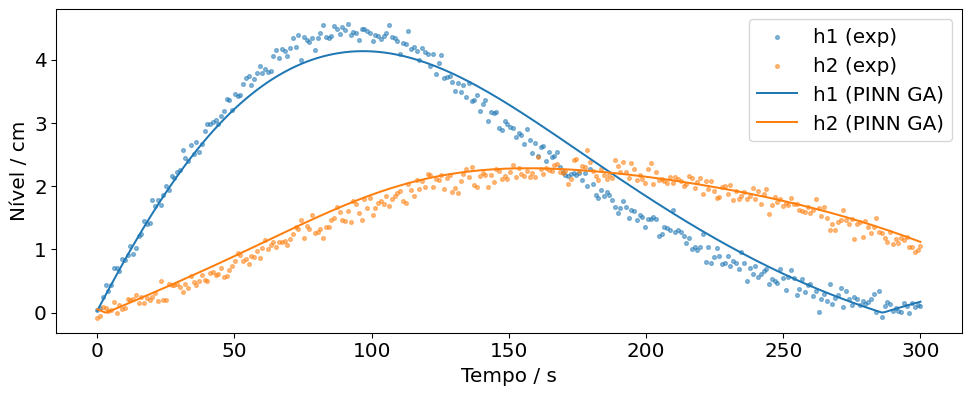

In [9]:
pinn_h1, pinn_h2 = test_model(GA_model)

# Gráfico
plot_tanks(
    t,
    (h1_exp, h2_exp, pinn_h1, pinn_h2),
    ["h1 (exp)", "h2 (exp)", "h1 (PINN GA)", "h2 (PINN GA)"],
    scatter=2,
)


In [10]:
for nome, param in GA_model.named_parameters():
    print(f"Nome: {nome}")
    print(f"Valor: {param}")


Nome: hidden_layer.0.weight
Valor: Parameter containing:
tensor([[ 1.0793],
        [-0.1387],
        [-1.3150],
        [ 0.3257],
        [-0.5656],
        [ 0.7433],
        [-0.1279],
        [ 0.7154]], requires_grad=True)
Nome: hidden_layer.0.bias
Valor: Parameter containing:
tensor([ 1.1546, -0.2044, -0.3934,  0.3114,  0.2269, -0.5096, -0.3363, -1.0832],
       requires_grad=True)
Nome: hidden_layer.2.weight
Valor: Parameter containing:
tensor([[ 1.1769, -0.2594, -1.4799,  1.3371,  1.9286, -0.6260,  1.6309, -0.7714],
        [ 0.0278, -0.7589, -0.0494, -0.4983, -0.6598, -0.4050, -0.0136,  0.4843],
        [ 0.0850,  0.2022, -0.1962,  1.9963, -0.3686,  0.5761,  0.7818,  2.4722],
        [ 1.7343, -1.8350,  0.7462,  0.7205,  0.6271, -0.7949,  0.3349,  0.5946],
        [-1.7439, -0.0392, -1.4196, -2.0145, -0.6192,  0.6849, -0.2255, -0.4560],
        [ 0.1694, -3.6950,  1.0167, -1.2920, -0.0112, -0.2467, -0.8512, -1.6377],
        [ 0.3613,  1.1489,  0.2347,  1.2716,  0.6412,  0.1